In [ ]:
import pygame
import numpy as np


pygame 2.6.1 (SDL 2.28.4, Python 3.12.2)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
pygame.init()
screen_width = 800
screen_height = 600
screen = pygame.display.set_mode((screen_width, screen_height))


In [575]:
m_cart = 10
m_pend = 1
L = 2
density = 1/10 # purely for visual scaling purposes
scale = 100
g= -9.81

cart_width = np.sqrt(density * m_cart * 2) * scale
cart_height = np.sqrt(density * m_cart / 2) * scale
pend_radius = np.sqrt(density * m_pend / np.pi) * scale
pole_length = L*scale

In [576]:
def draw_cart_pole(screen, x, theta, F=0):
    # Convert x and theta to screen coordinates
    cart_x = int(x * screen_width / 2 + screen_width / 2)
    cart_y = screen_height // 2 + cart_height

    # Draw the cart
    pygame.draw.rect(screen, (0, 0, 255), (cart_x - cart_width // 2, cart_y, cart_width, cart_height))

    # Draw the pole
    pole_x2 = cart_x + pole_length * np.sin(theta)
    pole_y2 = cart_y + pole_length * np.cos(theta)
    pygame.draw.line(screen, (0, 0, 0), (cart_x, cart_y), (pole_x2, pole_y2), 5)

    pygame.draw.circle(screen, (5, 5, 65), (pole_x2, pole_y2), pend_radius)
    
    arrow = np.array([[0,0], [1,0], [1,-0.5], [1.5,0.5], [1,1.5], [1,1], [0,1]]) * scale / 4
    arrow[:, 0] *= F / 2
    arrow += [cart_x, cart_y]
    pygame.draw.polygon(screen, (200, 0, 0), arrow)

In [577]:
x = 0
theta = 0
screen.fill((255, 255, 255))  # Fill the screen with white
draw_cart_pole(screen, x, theta, 10)
pygame.display.flip()

In [702]:
A = np.array([[0, 1, 0, 0],
              [0, 0, -m_pend*g/m_cart, 0],
              [0, 0, 0, 1],
              [0, 0, -(m_cart+m_pend)*g/(m_cart*L), 0]])
B = np.array([[0],
              [1/m_cart],
              [0],
              [1/(m_cart*L)]])

# The point around which A and B are linearised - we use this later to account for the constant term that comes from linearising sin(theta) @ pi
lin_point = np.array([0,0,np.pi,0])

np.linalg.eig(A)
desired_eigs = np.array([-1.5+0j, -1.4-0j, -1.3+0j, -1.2-0j])


In [658]:
# This method of pole placement doesn't really work

# ignore leading coefficient of 1
# np.polynomial.Polynomial.fromroots(desired_eigs).coef
d_coef = np.poly(desired_eigs)[1:]
a_coef = np.poly(A)[1:] 
bk_coef = d_coef - a_coef
K = np.zeros(A.shape[0])
for i in range(len(K)):
    K[i] = bk_coef[i] / B[i][0] if abs(B[i]) > 1e-6 else 0
K = np.atleast_2d(K)
K, np.linalg.eig(A-B@K)


(array([[ 0.   , 61.055,  0.   ,  0.24 ]]),
 EigResult(eigenvalues=array([ 0.        , -6.20974932, -2.15041405,  2.24266337]), eigenvectors=array([[ 1.        , -0.13795519,  0.05082148,  0.02014342],
        [ 0.        ,  0.85666713, -0.10928721,  0.04517491],
        [ 0.        , -0.07903034, -0.41859013,  0.40674857],
        [ 0.        ,  0.4907586 ,  0.90014209,  0.91220013]])))

In [706]:
from scipy import signal
placed = signal.place_poles(A, B, desired_eigs)
print(placed.gain_matrix, np.linalg.eigvals(A-B@placed.gain_matrix))
K = placed.gain_matrix
K, np.linalg.eig(A-B@K)


[[ -6.67889908 -19.9266055  339.46779816 147.85321101]] [-1.5 -1.4 -1.3 -1.2]


(array([[ -6.67889908, -19.9266055 , 339.46779816, 147.85321101]]),
 EigResult(eigenvalues=array([-1.5, -1.4, -1.3, -1.2]), eigenvectors=array([[-0.51074116,  0.55150453, -0.58968324, -0.62679563],
        [ 0.76611174, -0.77210634,  0.76658821,  0.75215476],
        [ 0.21641575, -0.18352273,  0.15498673,  0.13024325],
        [-0.32462362,  0.25693182, -0.20148275, -0.1562919 ]])))

In [707]:
goal = np.array([[0],
                [0],
                [np.pi],
                [0]])

def control(x_vec):
    """
    Return the control signal u
    Because B is [1, 0] for the cart pole, we just return F, the force on the cart in the x direction
    """
    return (-K@(x_vec.flatten()-goal.flatten()))[0]

def dynamics(t, x_vec, F):
    xdot = x_vec[1]
    theta = x_vec[2]
    thetadot = x_vec[3]
    # U = -Kx
    # F = control(x_vec)
    # print(f"F: {F}")
    St = np.sin(theta)
    Ct = np.cos(theta)

    # From https://underactuated.mit.edu/acrobot.html
    x_ddot = (F + m_pend*St*(L*thetadot**2 - g*Ct)) / (m_cart+m_pend*St**2)
    # (1/D)*(-m*g*Cx*Sx + (m*L*x(4)^2*Sx - d*x(2))) + (1/D)*u;
    thetaddot = (-F*Ct - m_pend*L*thetadot**2*Ct*St + (m_cart+m_pend)*g*St) / (L*(m_cart+m_pend*St**2))
    # (1/D)*((m+M)*g*Sx - Cx*(m*L*x(4)^2*Sx - d*x(2))) - Cx*(1/D)*u;

    return np.array([xdot, x_ddot, thetadot, thetaddot])

def lin_dynamics(x_vec, F):
    return A @ (x_vec-lin_point) + B @ [F]

x = np.array([[0, 0, 0, 1]]).T; print(dynamics(0, x, control(x)))
x = np.array([0, 0, 0, 1]); print(dynamics(0, x, control(x)))
x = np.array([0, 0, np.pi, 0]); assert np.allclose(dynamics(0, x, 0), lin_dynamics(x,0))


[[  0.        ]
 [ 91.86163298]
 [  1.        ]
 [-45.93081649]]
[  0.          91.86163298   1.         -45.93081649]


In [715]:
from scipy.integrate import solve_ivp
import time

t_eval = np.linspace(0,15,1500//2)
system = solve_ivp(lambda t,y: dynamics(t,y,control(y)), [0, 15], np.array([0,-0.5,3.,0.]), t_eval=t_eval)
# system = solve_ivp(lambda t,y: dynamics(t,y,0), [0, 15], np.array([0,0.,0.0,0.1]), t_eval=t_eval)
prev_t=0
carry = 0
# clock = pygame.time.Clock()
for step in range(len(system.t)):
    loop_start = time.time()
    t, y = system.t[step], system.y[:,step]
    # print(t,y)
    screen.fill((255, 255, 255))
    F = control(y)
    draw_cart_pole(screen, y[0], y[2], F)
    print(y, F)
    pygame.display.flip()
    if step < len(system.t)-1:
        wait_time = loop_start + system.t[step+1] - t - time.time() + carry
        if wait_time < 0:
            carry = wait_time
            wait_time = 0
        else:
            carry = 0
        time.sleep(wait_time)


[ 0.  -0.5  3.   0. ] 38.10284359805023
[-0.00929097 -0.42848747  3.00021879  0.02154364] 36.206223888113556
[-0.01718733 -0.36069531  3.0008507   0.04128971] 34.370319852616035
[-0.02376218 -0.29649535  3.00186099  0.0593412 ] 32.59376181949091
[-0.02908614 -0.23576278  3.00321681  0.07579601] 30.87524317036453
[-0.0332275  -0.17837606  3.00488705  0.09074732] 29.213514292141177
[-0.03625212 -0.12421687  3.00684237  0.10428354] 27.607382577004017
[-0.038224   -0.07316988  3.0090543   0.11649038] 26.055703471669872
[-0.03920543 -0.02512238  3.0114949   0.12745201] 24.55735705405794
[-0.03925438  0.02003454  3.01414166  0.13723939] 23.111268725294025
[-0.03842681  0.0624073   3.01697333  0.14592036] 21.716368600882966
[-0.03677693  0.10209993  3.01996954  0.15356054] 20.3715881607353
[-0.0343571   0.13921404  3.02311075  0.16022329] 19.075860249167686
[-0.03121795  0.17384889  3.02637831  0.16596974] 17.828119074903036
[-0.02740827  0.20610133  3.02975443  0.17085878] 16.62730021106965


KeyboardInterrupt: 

In [697]:
x = np.array([0,0.0,0,0.])
print(A)
x, A@x, B@[1], A@x + B@[1]

[[0.     1.     0.     0.    ]
 [0.     0.     0.981  0.    ]
 [0.     0.     0.     1.    ]
 [0.     0.     5.3955 0.    ]]


(array([0., 0., 0., 0.]),
 array([0., 0., 0., 0.]),
 array([0.  , 0.1 , 0.  , 0.05]),
 array([0.  , 0.1 , 0.  , 0.05]))

In [689]:
A

array([[0.    , 1.    , 0.    , 0.    ],
       [0.    , 0.    , 0.981 , 0.    ],
       [0.    , 0.    , 0.    , 1.    ],
       [0.    , 0.    , 5.3955, 0.    ]])

In [553]:
C = np.hstack((B, A@B, A@A@B, A@A@A@B))
C, np.linalg.matrix_rank(C)

(array([[ 0.    ,  0.1   ,  0.    , -0.0981],
        [ 0.1   ,  0.    , -0.0981,  0.    ],
        [ 0.    ,  0.1   ,  0.    , -1.0791],
        [ 0.1   ,  0.    , -1.0791,  0.    ]]),
 4)

In [ ]:

C = np.hstack((B, A@B, A@A@B, A@A@A@B))
C, np.linalg.matrix_rank(C)

EigResult(eigenvalues=array([-2.40149422+0.88231546j, -2.40149422-0.88231546j,
       -0.59850578+2.03418364j, -0.59850578-2.03418364j]), eigenvectors=array([[-0.31446029-0.11553356j, -0.31446029+0.11553356j,
         0.09903512+0.33659761j,  0.09903512-0.33659761j],
       [ 0.85711162+0.j        ,  0.85711162-0.j        ,
        -0.74397444+0.j        , -0.74397444-0.j        ],
       [-0.14207317+0.01041796j, -0.14207317-0.01041796j,
         0.15061702-0.19014574j,  0.15061702+0.19014574j],
       [ 0.33199597-0.15037201j,  0.33199597+0.15037201j,
         0.2966462 +0.420186j  ,  0.2966462 -0.420186j  ]]))

Gym - not useful as actions are just bang-bang (L/R) and we don't have a system model

""

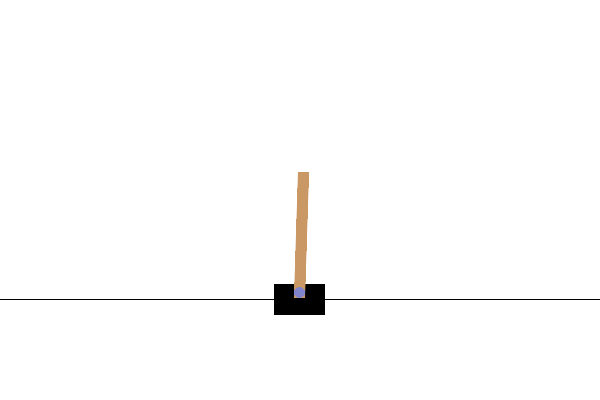

In [629]:
import gymnasium as gym
import mediapy as media

env = gym.make("CartPole-v1", max_episode_steps=300, render_mode="rgb_array")
observation, info = env.reset()
media.show_image(env.render())

Mujoco 2d pendulum

In [1]:
import mujoco
from mujoco import viewer
import numpy as np

In [5]:
model = mujoco.MjModel.from_xml_path('2D_pendulum.xml')
data = mujoco.MjData(model)

In [12]:
model.body(1)

<_MjModelBodyViews
  dofadr: array([0], dtype=int32)
  dofnum: array([1], dtype=int32)
  geomadr: array([0], dtype=int32)
  geomnum: array([1], dtype=int32)
  id: 1
  inertia: array([0.08395833, 0.08395833, 0.00125   ])
  invweight0: array([0.24953213, 0.99812851])
  ipos: array([0., 0., 0.])
  iquat: array([1., 0., 0., 0.])
  jntadr: array([0], dtype=int32)
  jntnum: array([1], dtype=int32)
  mass: array([1.])
  mocapid: array([-1], dtype=int32)
  name: ''
  parentid: array([0], dtype=int32)
  pos: array([0., 0., 0.])
  quat: array([1., 0., 0., 0.])
  rootid: array([1], dtype=int32)
  sameframe: array([1], dtype=uint8)
  simple: array([0], dtype=uint8)
  subtreemass: array([1.])
  user: array([], dtype=float64)
  weldid: array([1], dtype=int32)
>

In [21]:
model.geom(0)

<_MjModelGeomViews
  bodyid: array([1], dtype=int32)
  conaffinity: array([1], dtype=int32)
  condim: array([3], dtype=int32)
  contype: array([1], dtype=int32)
  dataid: array([-1], dtype=int32)
  friction: array([1.e+00, 5.e-03, 1.e-04])
  gap: array([0.])
  group: array([0], dtype=int32)
  id: 0
  margin: array([0.])
  matid: array([-1], dtype=int32)
  name: ''
  pos: array([0., 0., 0.])
  priority: array([0], dtype=int32)
  quat: array([1., 0., 0., 0.])
  rbound: array([0.50249378])
  rgba: array([1., 0., 0., 1.], dtype=float32)
  sameframe: array([1], dtype=uint8)
  size: array([0.05, 0.5 , 0.  ])
  solimp: array([9.0e-01, 9.5e-01, 1.0e-03, 5.0e-01, 2.0e+00])
  solmix: array([1.])
  solref: array([0.02, 1.  ])
  type: array([5], dtype=int32)
  user: array([], dtype=float64)
>

In [19]:
model.opt.gravity[2]

-9.81

In [22]:
data.qvel

array([0.])

In [24]:
np.all(np.equal(model.body(1).ipos, np.array([0., 0., 0.])))

True